<a href="https://colab.research.google.com/github/Jarvis-Geun/DeepLearning-Wiki/blob/main/XAI/SHAP_HTO/rf_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest model with SHAP

`-` Reference
- [Using SHAP Values to Explain How Your Machine Learning Model Works](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)
- [SHAP Values.ipynb](https://github.com/vinyluis/Articles/blob/main/Boruta%20SHAP/SHAP%20Values.ipynb)

## 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('default')

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 7.4 MB/s eta 0:00:00


## 2. Load dataset

In [157]:
from glob import glob
import pandas as pd

file_names = glob("*.xlsx")
# read xlsx format using pandas
# read only first index of the dataset
df = pd.read_excel(file_names[2], engine="openpyxl")

In [158]:
file_names

['3rd validation HTO_modif_Missing data delete_For AI_Outcome 5.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 1.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 2.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 3.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 4.xlsx']

In [159]:
df.head(5)

,case no.,PreWBL,Pre\nJLCA,Pre\nMPTA,Pre\nLDFA,Pre Coronal translation),PostWBL,Post\nJLCA,Post\nMPTA,Post\nLDFA,...,Delta Coronal translation,LJSW (Varus),MJSW (Valgus),VVD,"Sex (M:1, F:0)",Age,Height,Weight,BMI,Outcome
0,1,19.726354,4.926667,85.856667,87.710000,3.71,67.400222,3.973333,95.550000,87.026667,...,-1.00,6.72,7.21,-0.49,0,52,152,70,30.30,1
1,2,10.615200,6.420000,85.100000,89.050000,6.71,61.882716,7.350000,95.910000,86.193333,...,-2.25,11.19,9.14,2.05,0,62,149,51,22.97,1
2,3,-5.870595,22.423333,81.133333,90.900000,6.61,25.177793,4.176667,89.660000,91.566667,...,-0.83,8.04,5.65,2.39,0,53,148,68,31.04,1
3,4,31.436854,5.950000,86.766667,88.396667,8.28,58.257285,4.090000,91.866667,86.023333,...,-1.80,8.83,8.90,-0.07,1,61,169,80,28.01,1
4,5,22.523574,3.660000,87.806667,90.406667,6.39,54.622471,4.460000,93.120000,88.263333,...,-3.84,11.09,6.51,4.58,0,52,155,83,34.55,1


### Define X

In [160]:
X = df.iloc[:, :-1]
X.head(5)

,case no.,PreWBL,Pre\nJLCA,Pre\nMPTA,Pre\nLDFA,Pre Coronal translation),PostWBL,Post\nJLCA,Post\nMPTA,Post\nLDFA,...,∆LDFA,Delta Coronal translation,LJSW (Varus),MJSW (Valgus),VVD,"Sex (M:1, F:0)",Age,Height,Weight,BMI
0,1,19.726354,4.926667,85.856667,87.710000,3.71,67.400222,3.973333,95.550000,87.026667,...,-0.683333,-1.00,6.72,7.21,-0.49,0,52,152,70,30.30
1,2,10.615200,6.420000,85.100000,89.050000,6.71,61.882716,7.350000,95.910000,86.193333,...,-2.856667,-2.25,11.19,9.14,2.05,0,62,149,51,22.97
2,3,-5.870595,22.423333,81.133333,90.900000,6.61,25.177793,4.176667,89.660000,91.566667,...,0.666667,-0.83,8.04,5.65,2.39,0,53,148,68,31.04
3,4,31.436854,5.950000,86.766667,88.396667,8.28,58.257285,4.090000,91.866667,86.023333,...,-2.373333,-1.80,8.83,8.90,-0.07,1,61,169,80,28.01
4,5,22.523574,3.660000,87.806667,90.406667,6.39,54.622471,4.460000,93.120000,88.263333,...,-2.143333,-3.84,11.09,6.51,4.58,0,52,155,83,34.55


### Define y label

In [161]:
y = df.iloc[:, -1]
y.head(5)

0    1
1    1
2    1
3    1
4    1
Name: Outcome, dtype: int64

In [162]:
X.shape, y.shape

((327, 24), (327,))

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((261, 24), (66, 24), (261,), (66,))

## 3. Functions

In [164]:
def print_feature_importances_random_forest(random_forest_model):
  '''
  Prints the feature importances of a Random Forest model in an ordered way.
  random_forest_model -> The sklearn.ensemble.RandomForestClassifier or RandomForestRegressor trained model
  '''

  # Fetch the feature importances and feature names
  importances = random_forest_model.feature_importances_
  features = random_forest_model.feature_names_in_

  # Organize them in a dictionary
  feature_importances = {fea: imp for imp, fea in zip(importances, features)}

  # Sorts the dictionary
  feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

  # Prints the feature importances
  for k, v in feature_importances.items():
    print(f"{k} -> {v:.4f}")

In [165]:
def evaluate_classification(y, y_pred):
  '''
  Prints the most common evaluation metrics for classification
  '''

  mae = MAE(y, y_pred)
  mse = MSE(y, y_pred)
  rmse = mse ** (1/2)
  r2 = R2(y, y_pred)

  print("Classification result")
  print(f"MAE: {mae:.2f}")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R2: {r2:.2f}")

## 4. Random Forest Classifier

In [166]:
model = RandomForestClassifier()

In [167]:
model.fit(X_train, y_train)

RandomForestClassifier()

### Evaluate the model

In [168]:
y_pred = model.predict(X_test)
evaluate_classification(y_test, y_pred)

Classification result
MAE: 0.27
MSE: 0.27
RMSE: 0.52
R2: -0.16


In [169]:
# View accuracy score
accuracy_score(y_test, y_pred)

0.7272727272727273

In [170]:
# View confusion matrix for test data and predictions
# sum of confusion matrix is equal to y_test.shape
confusion_matrix(y_test, y_pred)

array([[15, 10],
       [ 8, 33]])

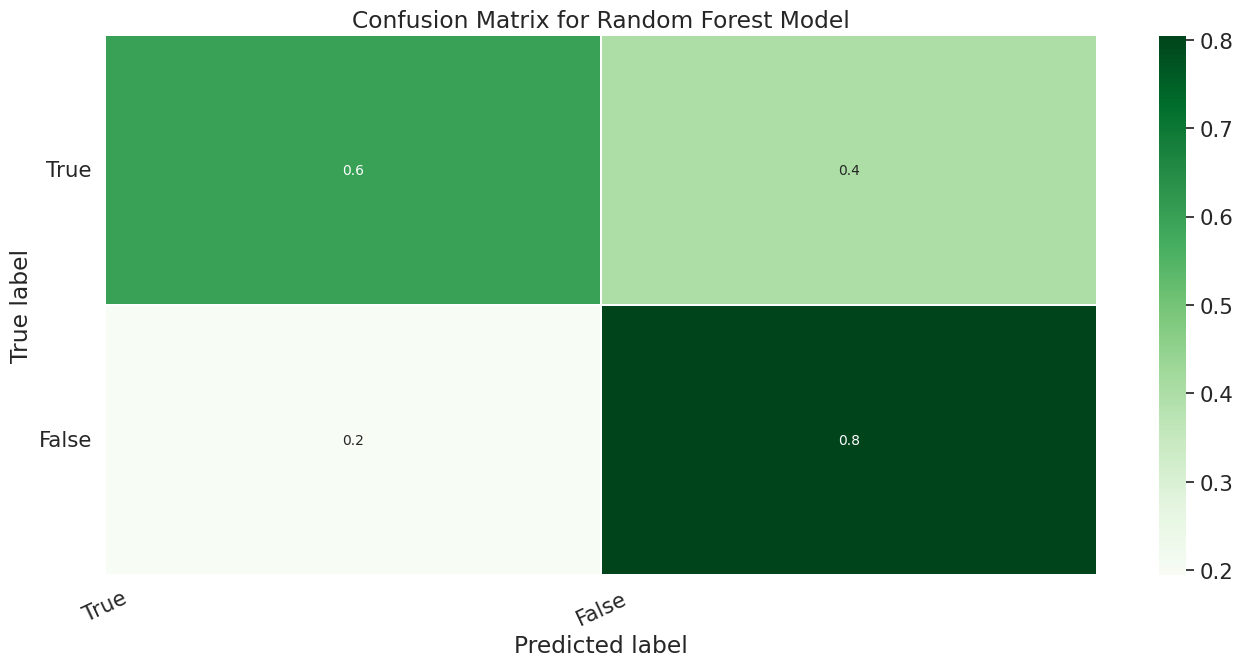

In [171]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['True', 'False']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [172]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.60      0.63        25
           1       0.77      0.80      0.79        41

    accuracy                           0.73        66
   macro avg       0.71      0.70      0.71        66
weighted avg       0.72      0.73      0.72        66



In [173]:
print_feature_importances_random_forest(model)

Post
MPTA -> 0.1365
Post
JLCA -> 0.0975
PostWBL -> 0.0561
Pre
JLCA -> 0.0541
∆MPTA -> 0.0531
∆WBLR -> 0.0467
Pre
LDFA -> 0.0463
Pre
MPTA -> 0.0425
∆JLCA -> 0.0398
PreWBL -> 0.0352
BMI -> 0.0350
Post
LDFA -> 0.0345
VVD -> 0.0338
Post Coronal translation -> 0.0337
∆LDFA -> 0.0321
case no. -> 0.0319
Pre Coronal translation) -> 0.0319
Height -> 0.0314
Weight -> 0.0273
Delta Coronal translation -> 0.0257
LJSW (Varus) -> 0.0255
Age -> 0.0234
MJSW (Valgus) -> 0.0226
Sex (M:1, F:0) -> 0.0035


## 5. SHAP

In [174]:
import shap

In [175]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
# shap_values variable (three attributes) : .values, .base_values, .data
shap_values = explainer(X_test)

Permutation explainer: 67it [00:28,  1.53it/s]


In [176]:
from scipy.special import softmax
import numpy as np

def print_feature_importances_shap_values(shap_values, features):
  '''
  Prints the feature importances based on SHAP values in an ordered way shap_values
  -> The SHAP values calculated from a shap.Explainer object features
  -> The name of the features, on the order presented to the explainer
  '''
  # Calculates the feature importance (mean absolute shap value) for each feature
  importances = []
  for i in range(shap_values.values.shape[1]):
    importances.append(np.mean(np.abs(shap_values.values[:, i])))

  # Calculates the normalized version
  importances_norm = softmax(importances)

  # Organize the importances and columns in a dictionary
  feature_importances = {fea: imp for imp, fea in zip(importances, features)}
  feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

  # Sorts the dictionary
  feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
  feature_importances_norm = {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse=True)}
  
  # Prints the feature importances
  for k, v in feature_importances.items():
    print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [177]:
print_feature_importances_shap_values(shap_values, X_test.columns)

Post
MPTA -> 0.2383 (softmax = 0.0510)
Post
JLCA -> 0.0747 (softmax = 0.0433)
PostWBL -> 0.0715 (softmax = 0.0431)
Pre
LDFA -> 0.0415 (softmax = 0.0419)
Pre
MPTA -> 0.0340 (softmax = 0.0416)
Height -> 0.0337 (softmax = 0.0415)
∆LDFA -> 0.0315 (softmax = 0.0415)
∆MPTA -> 0.0305 (softmax = 0.0414)
Pre
JLCA -> 0.0298 (softmax = 0.0414)
∆JLCA -> 0.0280 (softmax = 0.0413)
case no. -> 0.0264 (softmax = 0.0412)
PreWBL -> 0.0246 (softmax = 0.0412)
Post
LDFA -> 0.0236 (softmax = 0.0411)
Pre Coronal translation) -> 0.0236 (softmax = 0.0411)
∆WBLR -> 0.0235 (softmax = 0.0411)
Delta Coronal translation -> 0.0213 (softmax = 0.0410)
Post Coronal translation -> 0.0206 (softmax = 0.0410)
VVD -> 0.0177 (softmax = 0.0409)
LJSW (Varus) -> 0.0142 (softmax = 0.0407)
BMI -> 0.0115 (softmax = 0.0406)
Age -> 0.0105 (softmax = 0.0406)
MJSW (Valgus) -> 0.0097 (softmax = 0.0406)
Weight -> 0.0081 (softmax = 0.0405)
Sex (M:1, F:0) -> 0.0032 (softmax = 0.0403)


### Bar plot

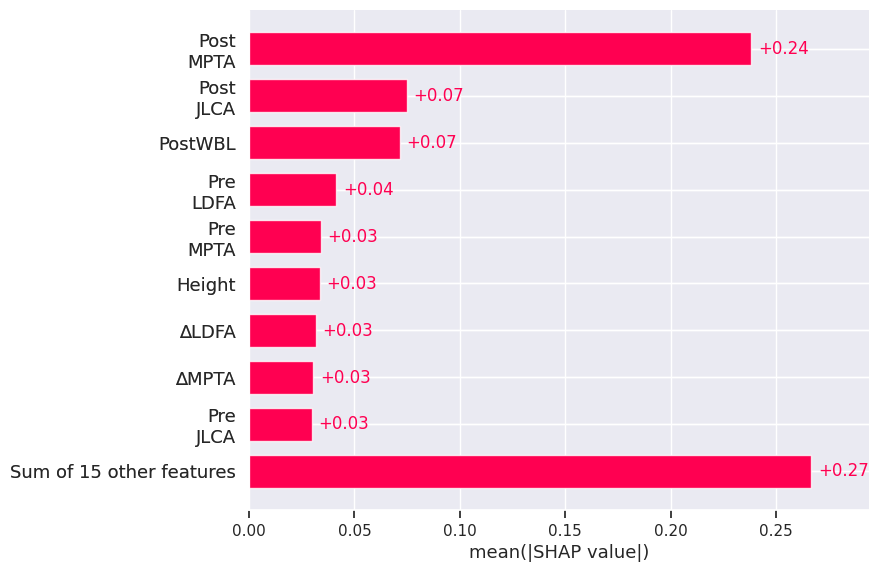

In [178]:
shap.plots.bar(shap_values)

### Summary plot: beeswarm

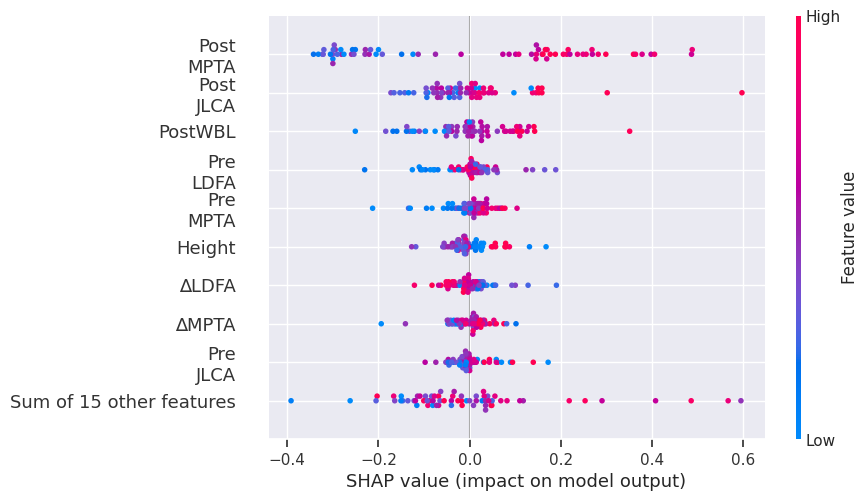

In [179]:
shap.plots.beeswarm(shap_values)

### Summary plot: violin

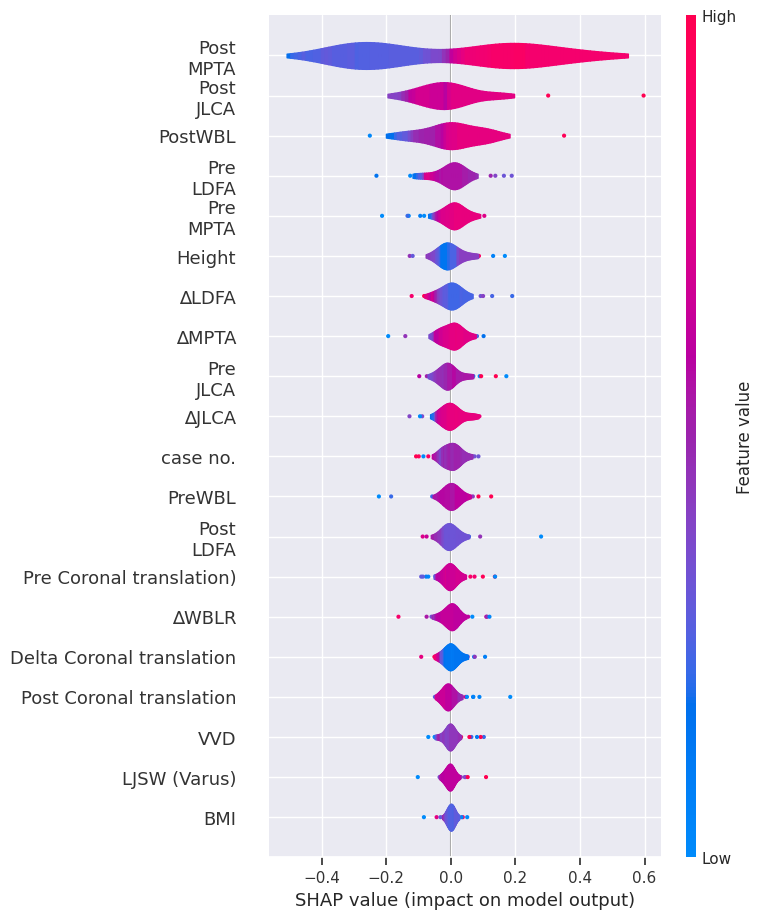

In [180]:
shap.summary_plot(shap_values, plot_type="violin")

### Local bar plot: single observation

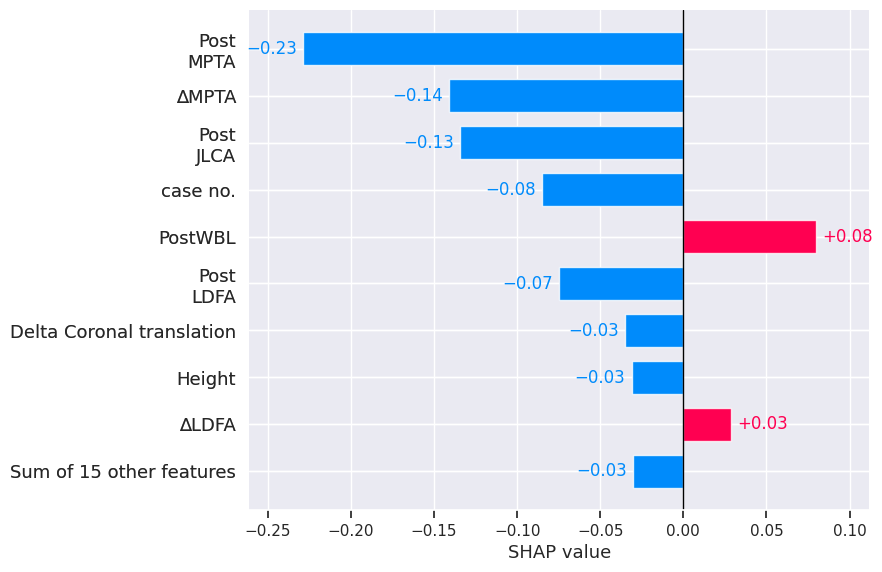

In [181]:
shap.plots.bar(shap_values[0])

### Waterfall plot

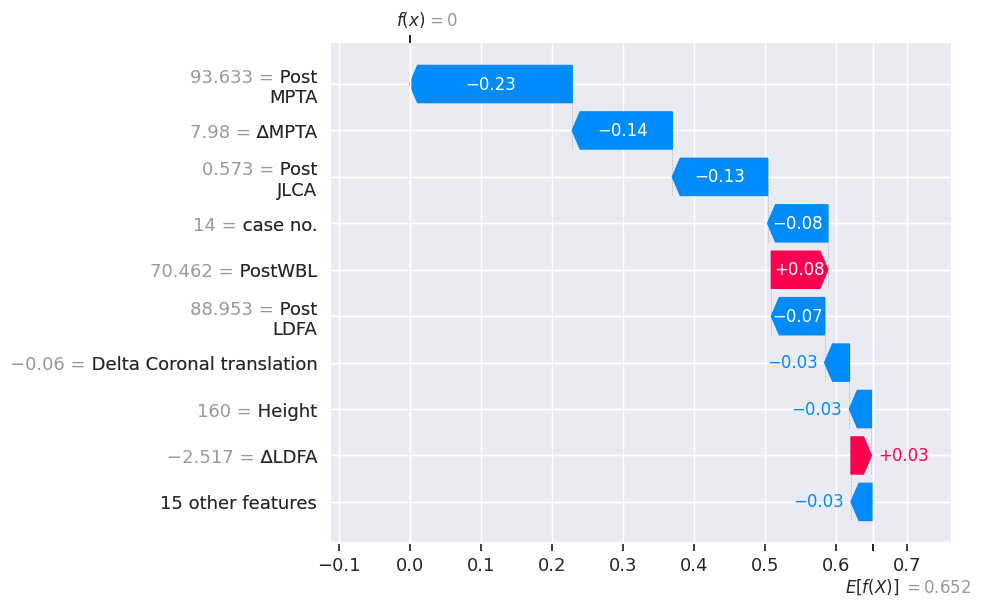

In [182]:
shap.plots.waterfall(shap_values[0])

### Force plot

In [183]:
shap_values[0]

.values =
array([-0.08484848, -0.02348485, -0.01742424,  0.0219697 , -0.02424242,
       -0.01515152,  0.07954545, -0.13409091, -0.22878788, -0.075     ,
       -0.00378788,  0.02727273, -0.00151515, -0.14090909,  0.02878788,
       -0.03484848, -0.01060606, -0.00378788,  0.00378788, -0.00227273,
        0.01212121, -0.03106061,  0.00151515,  0.00530303])

.base_values =
0.6515151515151515

.data =
array([ 1.40000000e+01,  7.74285033e+00,  2.51333333e+00,  8.56533333e+01,
        9.14700000e+01,  5.23000000e+00,  7.04621054e+01,  5.73333333e-01,
        9.36333333e+01,  8.89533333e+01,  5.17000000e+00,  6.27192551e+01,
       -1.94000000e+00,  7.98000000e+00, -2.51666667e+00, -6.00000000e-02,
        7.64000000e+00,  6.22000000e+00,  1.42000000e+00,  0.00000000e+00,
        6.00000000e+01,  1.60000000e+02,  6.00000000e+01,  2.34400000e+01])

In [184]:
shap.initjs()
shap.plots.force(shap_values[0])